# Real network

Corresponding to Cahpter 3.5, 3.7 in the book [Network Science Book](https://www.networksciencebook.com/) by Albert-László Barabási



In [1]:
!pip install torch xlrd networkx pandas torch_geometric 

Defaulting to user installation because normal site-packages is not writeable


## Load datasets


In [2]:
graph_list=[]

### C. elegans Connectome Dataset

Number of nodes: 283
Number of edges: 4693


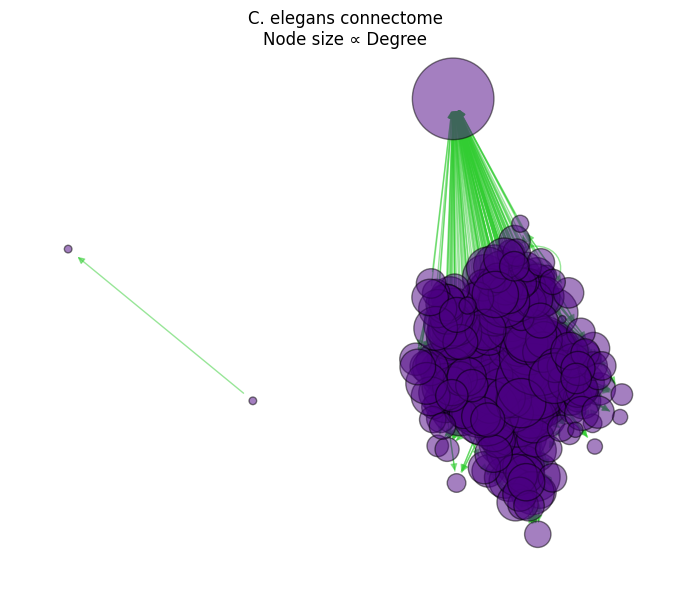

In [3]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# downloaded from https://www.wormwiring.org/
df = pd.read_excel('./Data/celegans_connectome.xls')

# Inspect the DataFrame to identify the correct columns
# print(df.columns)

G_celegans = nx.from_pandas_edgelist(df, source='Neuron 1', target='Neuron 2', create_using=nx.DiGraph())
graph_list.append(G_celegans)
print(f"Number of nodes: {G_celegans.number_of_nodes()}")
print(f"Number of edges: {G_celegans.number_of_edges()}")

def visualize_graph_with_degree_size(G, layout_func=nx.spring_layout, title="Graph Visualization"):
    """
    Visualize a graph where node size is proportional to its degree.
    
    Parameters:
        G (networkx.Graph): The input graph
        layout_func (function): Layout function like nx.spring_layout
        title (str): Title of the plot
    """
    degrees = dict(G.degree())
    node_sizes = [v * 30 for v in degrees.values()]  # scale factor

    pos = layout_func(G, seed=9)

    plt.figure(figsize=(7, 6))
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='indigo', edgecolors='black',alpha=0.5)
    nx.draw_networkx_edges(G, pos, alpha=0.5,edge_color='limegreen')
    # nx.draw_networkx_labels(G, pos, font_size=8)
    plt.title(f"{title}\nNode size ∝ Degree")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_graph_with_degree_size(G_celegans, title="C. elegans connectome")

note: positions of nodes are still randomly generated, same below

### Scientific Collaboration Network (COLLAB Dataset)

Number of nodes: 60
Number of edges: 478


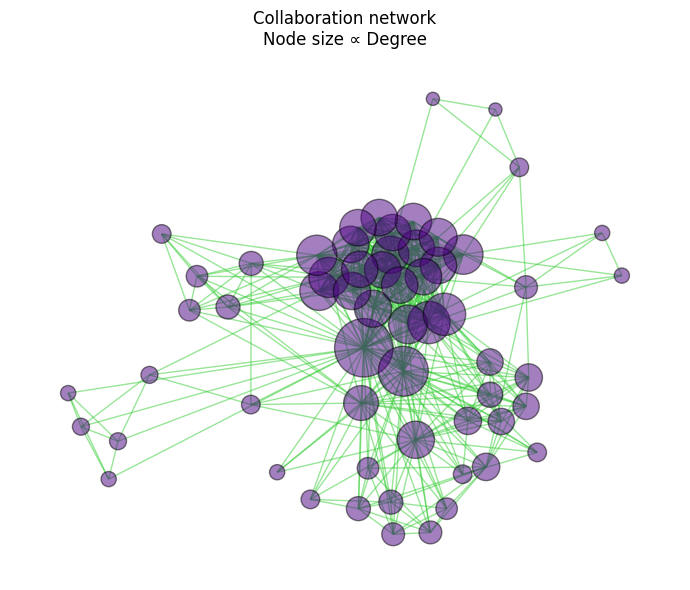

In [4]:
import networkx as nx
from torch_geometric.datasets import TUDataset
from torch_geometric.utils import to_networkx
# Download the COLLAB dataset
dataset = TUDataset(root='./Data/', name='COLLAB')

# Let's convert the 209th graph in the dataset
pyg_graph = dataset[209]
G_collab = to_networkx(pyg_graph, to_undirected=True)


print(f"Number of nodes: {G_collab.number_of_nodes()}")
print(f"Number of edges: {G_collab.number_of_edges()}")
graph_list.append(G_collab)

visualize_graph_with_degree_size(G_collab, title="Collaboration network")

### Social network (Facebook)

Number of nodes: 4039
Number of edges: 88234


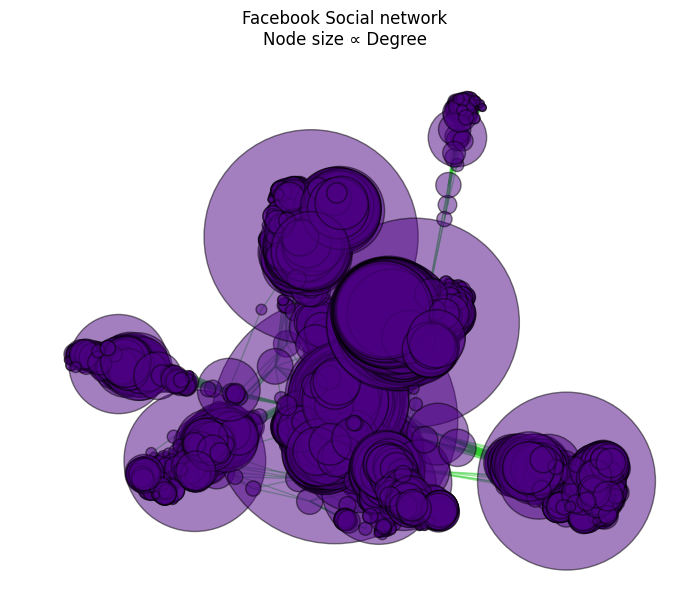

In [5]:
# Download from Stanford Large Network Dataset Collection https://snap.stanford.edu/data/ego-Facebook.html

import networkx as nx

# Load an edge list
G_social =  nx.read_edgelist("./Data/facebook_combined.txt", nodetype=int)


print(f"Number of nodes: {G_social.number_of_nodes()}")
print(f"Number of edges: {G_social.number_of_edges()}")

graph_list.append(G_social)

visualize_graph_with_degree_size(G_social, title="Facebook Social network")

## degree distribution for real network

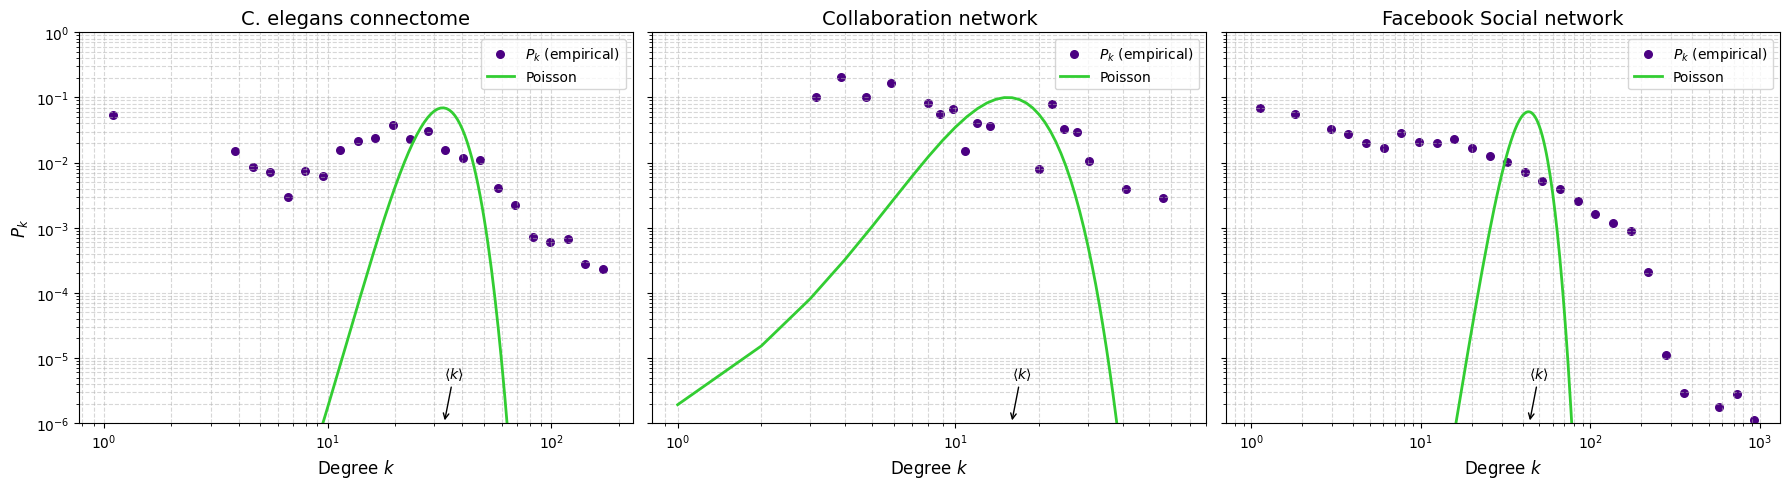

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import scipy.stats as stats

import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import scipy.stats as stats

def log_binned_degree_distribution(degrees, bins=30):
    """
    Compute log-binned degree distribution: returns midpoints and probability density.
    """
    degrees = np.array(degrees)
    min_deg = max(degrees.min(), 1)  # avoid log(0)
    max_deg = degrees.max()
    log_bins = np.logspace(np.log10(min_deg), np.log10(max_deg), bins)

    hist, bin_edges = np.histogram(degrees, bins=log_bins, density=True)
    bin_centers = (bin_edges[:-1] * bin_edges[1:])**0.5  # geometric mean
    return bin_centers, hist

def plot_log_degree_distributions(graph_list, titles=None, bins=30):
    n_graphs = len(graph_list)
    fig, axes = plt.subplots(1, n_graphs, figsize=(6 * n_graphs, 5), sharey=True)

    if n_graphs == 1:
        axes = [axes]

    for i, (G, ax) in enumerate(zip(graph_list, axes)):
        degrees = [d for _, d in G.degree()]
        k_avg = np.mean(degrees)

        # Log-binned empirical degree distribution
        k_vals, pk_vals = log_binned_degree_distribution(degrees, bins=bins)

        # Poisson distribution (binned)
        k_range = np.arange(0, int(np.max(k_vals)) + 10)
        poisson_probs = stats.poisson.pmf(k_range, mu=k_avg)
        poisson_k = k_range[k_range > 0]
        poisson_pk = poisson_probs[k_range > 0]

        # Plot
        ax.scatter(k_vals, pk_vals, color="indigo", s=30, label=r"$P_k$ (empirical)")
        ax.plot(poisson_k, poisson_pk, color="limegreen", lw=2, label="Poisson")

        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_ylim([10**(-6),10**(0)])
        ax.set_xlabel("Degree $k$", fontsize=12)
        if i == 0:
            ax.set_ylabel(r"$P_k$", fontsize=12)

        title = titles[i] if titles else f"Graph {i+1}"
        ax.set_title(title, fontsize=14)
        ax.grid(True, which="both", linestyle='--', alpha=0.5)
        ax.legend(fontsize=10)

        # Indicate <k>
        ax.annotate(r"$\langle k \rangle$", xy=(k_avg, 1e-6), xytext=(k_avg, 5e-6),
                    arrowprops=dict(arrowstyle='->'), fontsize=10)

    plt.tight_layout()
    plt.show()


plot_log_degree_distributions(graph_list,titles=["C. elegans connectome","Collaboration network","Facebook Social network"])

## Real networks are supercritical

In [16]:
for graph in graph_list:
    print(f"Number of nodes: {graph.number_of_nodes()}, Number of edges: {graph.number_of_edges()}, logN: {np.log(graph.number_of_nodes())}, <k>: { graph.number_of_edges()/graph.number_of_nodes()*2 }")
   


Number of nodes: 283, Number of edges: 4693, logN: 5.645446897643238, <k>: 33.1660777385159
Number of nodes: 60, Number of edges: 478, logN: 4.0943445622221, <k>: 15.933333333333334
Number of nodes: 4039, Number of edges: 88234, logN: 8.303752415563412, <k>: 43.69101262688784
